In [1]:
import networkx as nx
import numpy as np

In [2]:
def importGraphNX(path):
    ## import data
    allEdges = np.loadtxt(path+"_A.txt", dtype=tuple, delimiter=",")
    edgeLabels = np.loadtxt(path+"_edge_labels.txt", dtype=int, delimiter="\n")
    graphIndicator = np.loadtxt(path+"_graph_indicator.txt", dtype=int, delimiter="\n")
    graphLabels = np.loadtxt(path+"_graph_labels.txt", dtype=int, delimiter="\n")
    nodeLabels = np.loadtxt(path+"_node_labels.txt", dtype=int, delimiter="\n")
    
    ## create nx graphs
    allGraphs = [nx.Graph(label=x) for x in graphLabels]
    
    ## add all nodes and edges
    for index, (nodeA, nodeB) in enumerate(allEdges):
        nodeA = int(nodeA)
        nodeB = int(nodeB)
        graph = allGraphs[graphIndicator[nodeA-1] - 1]
        if nodeA not in graph.nodes:
            graph.add_node(nodeA, label=nodeLabels[nodeA-1])
        if nodeB not in graph.nodes:
            graph.add_node(nodeB, label=nodeLabels[nodeA-1])
            
        graph.add_edge(nodeA, nodeB, label=edgeLabels[index])
    
    
    
    return allGraphs
    
    

In [3]:
allGraphs = importGraphNX("MUTAG/MUTAG")

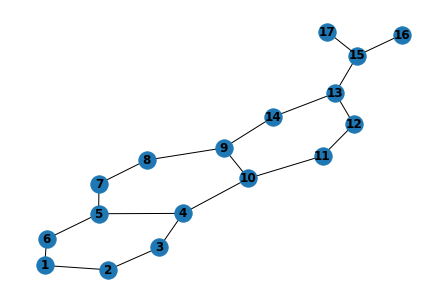

In [4]:
import matplotlib.pyplot as plt

G = allGraphs[0]
nx.draw(G, with_labels=True, font_weight='bold')

In [29]:
import itertools
from collections import defaultdict
def createGramTable(G, K):
    gramTable = defaultdict(lambda: defaultdict(int))
    
    for k in range(K):
        normalisingFactor = 0
        target = nx.complete_graph(k+1)
        for sub_nodes in itertools.combinations(G.nodes(),len(target.nodes())):
            subg = G.subgraph(sub_nodes)
            if nx.is_connected(subg):
                subgKey = nx.weisfeiler_lehman_graph_hash(subg, edge_attr="label", node_attr="label")
                gramTable[k][subgKey] += 1
                normalisingFactor += 1
        
        for key in gramTable[k].keys():
            gramTable[k][key] /= normalisingFactor
    
    return gramTable
            

In [32]:
def computeGraphletKernel(GT1, GT2, K):
    inner_product = 0
    for k in range(K):
        for key in GT1[k].keys():
            if key in GT2[k]:
                inner_product += GT1[k][key]*GT2[k][key]
    
    return inner_product
                

In [31]:
%%time
GramVector = []
for graph in allGraphs:
    GramVector.append(createGramTable(graph, 5))

CPU times: total: 1min 5s
Wall time: 1min 5s


In [39]:
%%time
GraphletKernel = []
sameClass = []
diffClass = []
graphLabels = np.loadtxt("MUTAG/MUTAG_graph_labels.txt", dtype=int, delimiter="\n")
for i in range(len(GramVector)):
    for j in range(i+1, len(GramVector)):
        similarity = computeGraphletKernel(GramVector[i],GramVector[j], 5)
        GraphletKernel.append(similarity)
        if graphLabels[i] == graphLabels[j]:
            sameClass.append(similarity)
        else:
            diffClass.append(similarity)

CPU times: total: 93.8 ms
Wall time: 100 ms


In [40]:
GraphletKernel

[2.047254766572648,
 2.0505709445779434,
 2.343439648486306,
 1.636275855709358,
 2.2024833311261864,
 2.128099344688051,
 1.6920229287856394,
 0.5419829632815931,
 1.8913583248835637,
 2.9801426799204735,
 2.9324705135288127,
 2.0829989538738944,
 0.4972219476409378,
 3.0889564185548233,
 2.0745270699638705,
 1.6706861545487168,
 1.83290038358229,
 2.0769496154231977,
 1.8043213600525627,
 1.9036456564946302,
 1.842915418309169,
 2.7304617963526954,
 3.267530793390573,
 1.8498358335340825,
 1.43549367063831,
 3.1857779927536107,
 1.842915418309169,
 1.4295372568943208,
 2.74589759431768,
 2.0689500435610992,
 1.4558484490613053,
 1.469440681226585,
 2.773640799884589,
 1.8588718598780172,
 2.5616661242534238,
 2.163853826745899,
 2.26144125343627,
 1.7851860866723697,
 2.7248646372900565,
 1.842915418309169,
 0.4972469538925007,
 2.356815921680893,
 1.9152520431801787,
 1.6093176439312435,
 2.6334309028181555,
 1.522896284782807,
 3.0141091814159116,
 1.6031169148463937,
 2.2144374353

### Analysis of similarity

In [49]:
from statistics import mean,stdev
mean(sameClass), mean(diffClass)

(1.5271443995560843, 1.2935106061282395)

In [50]:
stdev(sameClass), stdev(diffClass)

(0.5770147854271847, 0.4854687077701294)

(array([ 950.,  363., 1832., 2531., 1908., 1016.,  543.,  301.,  195.,
          64.]),
 array([0.34914299, 0.66036844, 0.9715939 , 1.28281935, 1.5940448 ,
        1.90527025, 2.2164957 , 2.52772116, 2.83894661, 3.15017206,
        3.46139751]),
 <BarContainer object of 10 artists>)

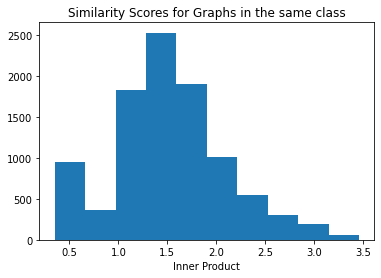

In [47]:
import matplotlib.pyplot as plt
plt.xlabel("Inner Product")
plt.title('Similarity Scores for Graphs in the same class')
plt.hist(sameClass)

(array([1281.,  256., 1074., 2082., 1530.,  959.,  472.,  127.,   68.,
          26.]),
 array([0.35511137, 0.61833317, 0.88155498, 1.14477678, 1.40799858,
        1.67122038, 1.93444218, 2.19766398, 2.46088578, 2.72410758,
        2.98732938]),
 <BarContainer object of 10 artists>)

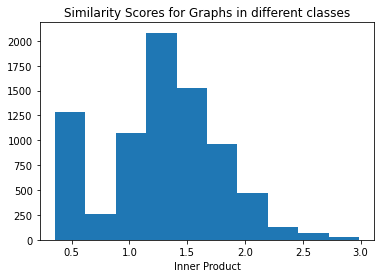

In [48]:
plt.xlabel("Inner Product")
plt.title('Similarity Scores for Graphs in different classes')
plt.hist(diffClass)